In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reverse Analysis: Estimating Parameters from Data

My understanding is we often have measurements of contaminant concentrations with more certainty, but the parameters ($\theta$) have higher degreres if uncertainty or are unknown. We want to find the set of parameters that best explains our observations or a trophic magnification curve but inform them with our best guess.

## 1. The Inverse Formulation

We start with the equilibrium condition:
$$ \mathbf{b}(\theta) - \mathbf{M}(\theta) \cdot \mathbf{C}_{obs} = 0 $$

Since the matrix $\mathbf{M}$ and vector $\mathbf{b}$ are linear functions of the parameters $\theta$, we can rearrange this equation to isolate $\theta$:

$$ \mathbf{K}(C_{obs}) \cdot \theta = \mathbf{r}(C_{obs}) $$

Where:
*   $\mathbf{K}$ is a constraint matrix derived from the biological flows (Consumption, Mortality) and observed concentrations.
*   $\mathbf{r}$ is a residual vector representing the net flux that must be balanced by the parameters. 

## 2. The Nullspace

The reformulation either yields no solution or infinitely many as a result of more parameters than concentration observations. This means there isn't just one solution, but an infinite subspace of valid solutions.

*   **Optimization:** We can find the "best" solution closest to our prior estimates.
*   **Sampling:** We can explore the "Nullspace" to generate an ensemble of all physically valid parameter sets.

In [15]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyewe as ewe

# Add source to path
sys.path.append("../src")

from ecotracer_analytics.core import EcopathSource, EcotracerSource
from ecotracer_analytics.linear_system import calculate_equilibrium
from ecotracer_analytics.dynamics import simulate_dynamics
from ecotracer_analytics.reverse_analysis import (
    ParameterDefinition, 
    LinearConstraintBuilder, 
    ConstrainedSolver
)

plt.style.use('seaborn-v0_8')

## 3. Setup: "Synthetic" Ground Truth

Use the model's original parameters to generate a "Ground Truth" set of concentrations. We will then try to solve for these parameters (or possible alternatives) knowing only the concentrations.

In [16]:
MODEL_PATH = "East Bass Strait.eiixml"
SCENARIO_ECOSIM = "constant fishing"
SCENARIO_ECOTRACER = "smaller_equi"

print("Loading Model...")
model = ewe.EwEScenarioInterface(MODEL_PATH, ecosim_scenario=SCENARIO_ECOSIM, ecotracer_scenario=SCENARIO_ECOTRACER)
model.run_scenarios(pd.DataFrame({"scenario": [1]}))
core = model._core_instance

path_source = EcopathSource(core)
gt_source = EcotracerSource(core) # Ground Truth Source

# 1. Calculate the "Observed" Equilibrium using Ground Truth Parameters
C_obs = calculate_equilibrium(path_source, gt_source)
print(f"Generated synthetic observations for {len(C_obs)} groups.")

Loading Model...


Running scenarios:   0%|          | 0/1 [00:00<?, ?it/s]

Generated synthetic observations for 60 groups.


## 4. Fixing Parameters and Defining Bounds

We initialize a `ParameterDefinition` object. By default, it reads the current parameters from the model as "Priors" or initial guesses.

In [17]:
param_def = ParameterDefinition(path_source, gt_source)

# Let's inspect the first few parameters
print("First 5 Parameters (Default):")
for p in param_def.params[:5]:
    print(f"  {p.name}: Prior={p.prior:.4f} [{p.lb}, {p.ub}]")

# Configuration:
# Fix Base Inflow (Param 0)
param_def.params[0].is_fixed = True

for param in param_def.params[1:]:
    param.lb = param.prior * 0.5
    param.ub = param.prior * 1.5

    
    if param.param_type == "assim_eff":
        if param.prior == 1:
            param.lb = 1
            param.ub = 1
            param.prior = 1
            param.is_fixed = True
        else:
            param.ub = min(param.ub, 1.0)
            param.prior = min(param.prior, 1.0)
        
    if param.lb == param.ub:
        param.is_fixed = True

    # Suppose that our initial guess was actually 5% larger for all parameters than a solution that would produce equilibrium
    if not param.is_fixed:
        param.prior = min(1.05 * param.prior, param.ub)

    if (param.prior == param.ub or param.prior == param.lb) and param.prior != 0 and not param.is_fixed:
        print(param)
    if param.prior > param.ub or param.prior < param.lb:
        print(f"Bounds Violations with: {param}")

print("\nConfiguration updated: Base Inflow fixed, others relaxed.")

First 5 Parameters (Default):
  Base Inflow: Prior=0.0000 [0.0, inf]
  Uptake_0: Prior=0.0000 [0.0, inf]
  Uptake_1: Prior=0.0000 [0.0, inf]
  Uptake_2: Prior=0.0000 [0.0, inf]
  Uptake_3: Prior=0.0000 [0.0, inf]

Configuration updated: Base Inflow fixed, others relaxed.


## 5. Building Constraints and Solving

We construct the linear system $\mathbf{K} \cdot \theta = \mathbf{r}$ based on our $C_{obs}$.
Then we ask the solver to find the parameter set $\theta^*$ that satisfies these constraints while remaining as close as possible to the initial guess.

In [18]:
# Build Matrix K and Vector r
builder = LinearConstraintBuilder(path_source, gt_source, param_def)
K, r = builder.build(C_obs)

print(f"Constraint Matrix Shape: {K.shape} (Constraints x Parameters)")

# Solve for Optimal Parameters
solver = ConstrainedSolver()
theta_opt, active_mask = solver.solve(K, r, param_def)

print("Optimization Complete.")

Constraint Matrix Shape: (60, 298) (Constraints x Parameters)
Optimization Complete.


## 6. Nullspace Sampling

Since the system likely has infinitely many solutions, `theta_opt` is just one of many possibilities. 
We use Hit-and-Run Sampling to generate 1000 alternative parameter sets that also satisfy $\mathbf{K} \cdot \theta = \mathbf{r}$ exactly.

In [19]:
N_SAMPLES = 1000
print(f"Sampling {N_SAMPLES} solutions from the Nullspace...")

samples = solver.sample(
    K, r, param_def,
    n_samples=N_SAMPLES,
    x_center=theta_opt # Center sampling around the optimum we found
)

print(f"Samples shape: {samples.shape}")

Sampling 1000 solutions from the Nullspace...
Nullspace dimension: 65
Samples shape: (1000, 298)


## 7. Visualization: Parameter Identifiability

We can visualize the uncertainty in our estimates.

### A. Parameter Distributions
Let's look at the "Uptake Rate" for a specific group (e.g., Group 5: Flathead). 
The red line indicates the Ground Truth value used to generate the data.

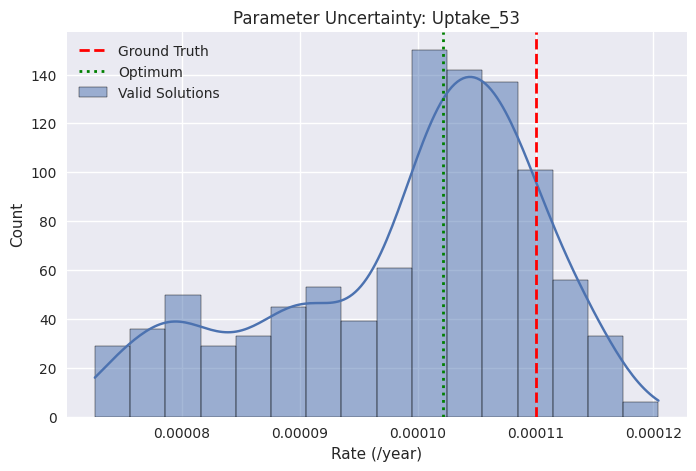

In [20]:
# Find index for "Uptake_50"
target_name = "Uptake_53"
p_idx = next(p.index for p in param_def.params if p.name == target_name)
gt_value = gt_source.dir_abs_r[53]

plt.figure(figsize=(8, 5))
sns.histplot(samples[:, p_idx], kde=True, label="Valid Solutions")
plt.axvline(gt_value, color='red', linestyle='--', linewidth=2, label="Ground Truth")
plt.axvline(theta_opt[p_idx], color='green', linestyle=':', linewidth=2, label="Optimum")
plt.title(f"Parameter Uncertainty: {target_name}")
plt.xlabel("Rate (/year)")
plt.legend()
plt.show()

### B. Parameter Correlations (Trade-offs)

Often, parameters are correlated. For example, a group can maintain the same concentration by having High Uptake and High Decay, or Low Uptake and Low Decay. $K$ is extremely sparse and if it wasn't for excretion and metabolic flows to the environment the system would be able to be decomposed for each functional group.

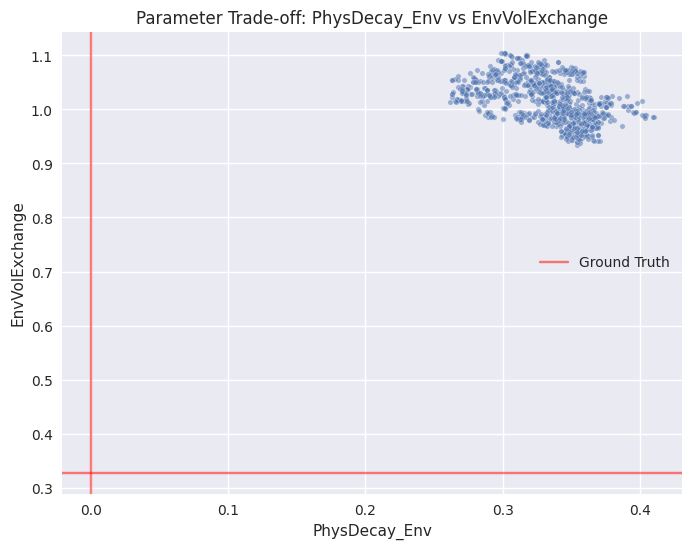

In [21]:
name_x = "PhysDecay_Env"
name_y = "EnvVolExchange"
idx_x = next(p.index for p in param_def.params if p.name == name_x)
idx_y = next(p.index for p in param_def.params if p.name == name_y)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=samples[:, idx_x], y=samples[:, idx_y], alpha=0.5, s=15)
plt.axvline(gt_source.dir_abs_r[5], color='red', alpha=0.5)
plt.axhline(gt_source.meta_dec_r[5], color='red', alpha=0.5, label="Ground Truth")

plt.title(f"Parameter Trade-off: {name_x} vs {name_y}")
plt.xlabel(name_x)
plt.ylabel(name_y)
plt.legend()
plt.grid(True)
plt.show()

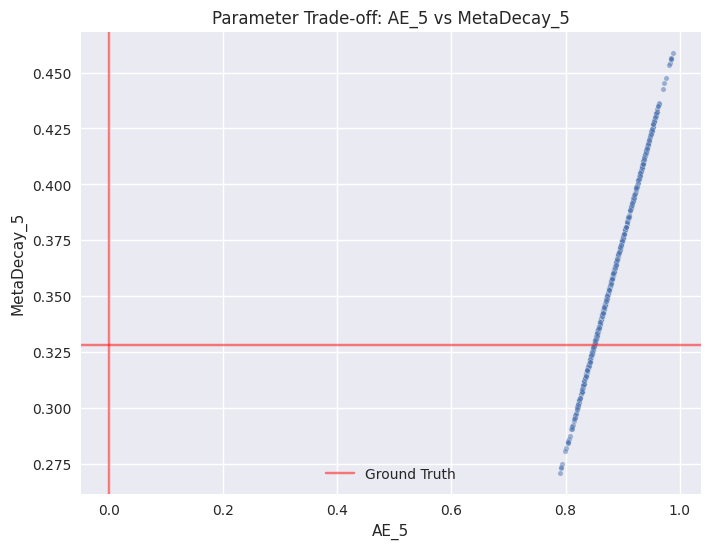

In [22]:
name_x = "AE_5"
name_y = "MetaDecay_5"
idx_x = next(p.index for p in param_def.params if p.name == name_x)
idx_y = next(p.index for p in param_def.params if p.name == name_y)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=samples[:, idx_x], y=samples[:, idx_y], alpha=0.5, s=15)
plt.axvline(gt_source.dir_abs_r[5], color='red', alpha=0.5)
plt.axhline(gt_source.meta_dec_r[5], color='red', alpha=0.5, label="Ground Truth")

plt.title(f"Parameter Trade-off: {name_x} vs {name_y}")
plt.xlabel(name_x)
plt.ylabel(name_y)
plt.legend()
plt.grid(True)
plt.show()

## 8. Ensemble Simulation: Propagating Uncertainty

Finally, we want to see how this parameter uncertainty propagates into future predictions.

We will:
1.  Take our ensemble of 1000 valid parameter sets.
2.  Apply a perturbation: **Double the Base Inflow**.
3.  Simulate the dynamics for *each* parameter set.
4.  Plot the trajectories.

This will show us the spread for our predictions and how different parametrisations of the same equlibrium may yield different predictions.

Running simulations for 1000 parameter sets...


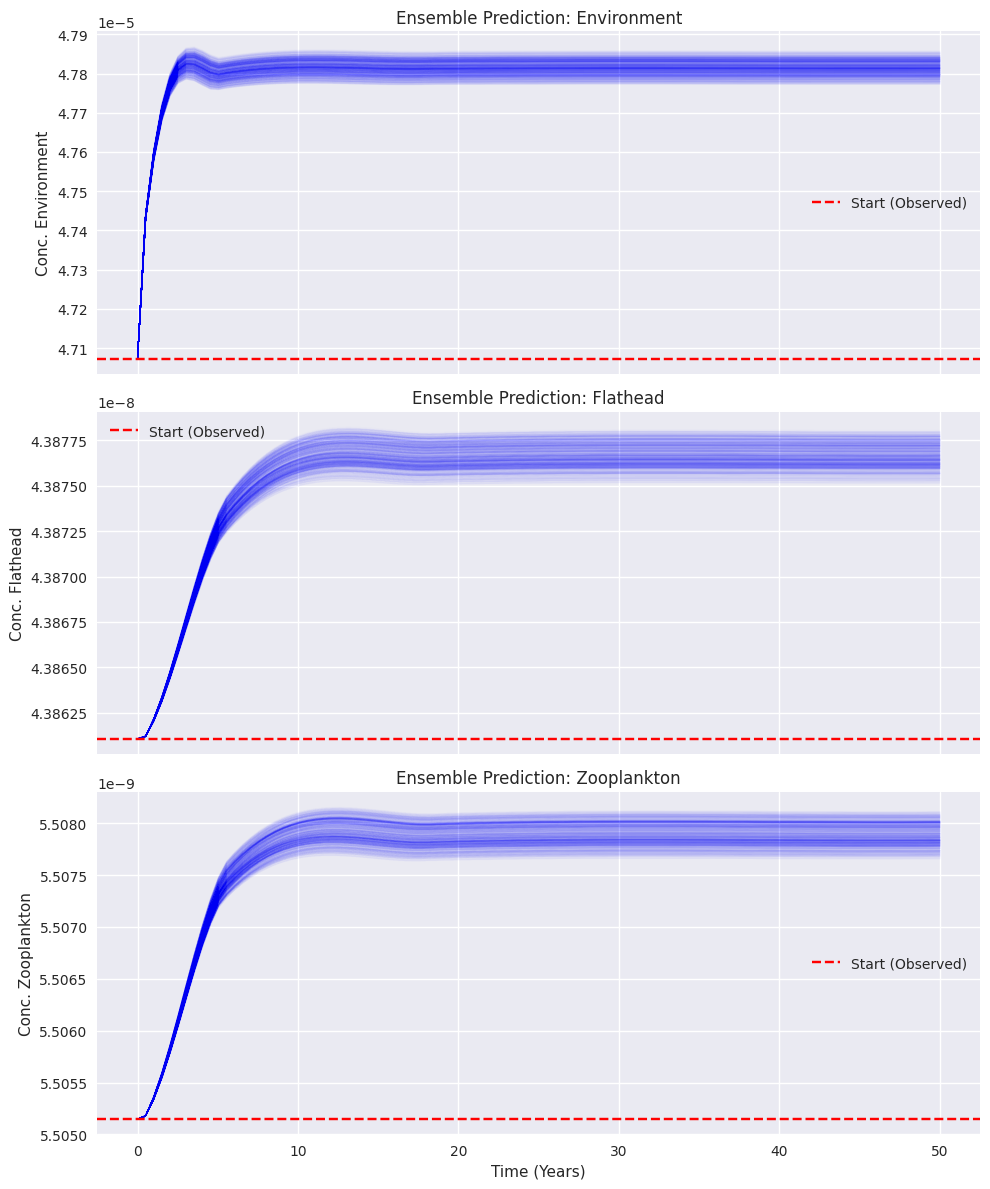

In [24]:
# %% # Simulation Settings
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 100)
new_inflow = param_def.params[0].prior * 2.0  # Double the original inflow

# Select a few groups to plot
groups_to_plot = [
    (0, "Environment"),
    (5, "Flathead"),
    (20, "Zooplankton")
]

fig, axes = plt.subplots(len(groups_to_plot), 1, figsize=(10, 12), sharex=True)

print(f"Running simulations for {N_SAMPLES} parameter sets...")

sim_source = EcotracerSource(core) 

# Iterate over a subset of samples to save time if N_SAMPLES is huge, 
# but 1000 is fast enough for linear systems.
for i in range(N_SAMPLES):
    theta = samples[i]
    sim_source = builder._create_tracer_source_with_params(theta)
    sim_source.base_inflow = new_inflow # APPLY PERTURBATION

    # 2. Simulate
    # Start from the OBSERVED equilibrium (C_obs)
    sol = simulate_dynamics(path_source, sim_source, C_obs, t_span, t_eval=t_eval, method="Radau")
    
    # 3. Plot
    # Use high transparency (low alpha) to visualize density
    for ax, (g_idx, g_name) in zip(axes, groups_to_plot):
        ax.plot(sol.t, sol.y[g_idx, :], color='blue', alpha=0.01, linewidth=1)

# Formatting
for ax, (g_idx, g_name) in zip(axes, groups_to_plot):
    ax.set_ylabel(f"Conc. {g_name}")
    ax.set_title(f"Ensemble Prediction: {g_name}")
    # Plot the starting point
    ax.axhline(C_obs[g_idx], color='red', linestyle='--', label="Start (Observed)")
    if i == N_SAMPLES - 1: # Add legend only once
        ax.legend()

axes[-1].set_xlabel("Time (Years)")
plt.tight_layout()
plt.show()